# Engineer features and convert time series data to images

## Imports & Settings

To install `talib` with Python 3.7 follow [these](https://medium.com/@joelzhang/install-ta-lib-in-python-3-7-51219acacafb) instructions.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import pandas as pd

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2001-01-01'
END = '2017-12-31'

In [5]:
sns.set_style('white')
idx = pd.IndexSlice

In [ ]:
results_path = Path('results', 'cnn_for_trading')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Model Data

In [6]:
with pd.HDFStore('data.h5') as store:
    features = store.get('features')
    targets = store.get('targets')

In [7]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2378283 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('ZTS', Timestamp('2017-12-28 00:00:00'))
Columns: 300 entries, 06_RSI to 85_CMA
dtypes: float64(300)
memory usage: 5.3+ GB


In [8]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2378283 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('ZTS', Timestamp('2017-12-28 00:00:00'))
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   r01_fwd     float64
 1   r01dec_fwd  float64
 2   r05_fwd     float64
 3   r05dec_fwd  float64
dtypes: float64(4)
memory usage: 81.9+ MB


## Select Features using Mutual Information

In [9]:
mi = {}
for t in [1, 5]:
    target = f'r{t:02}_fwd'
    df = features.join(targets[target]).dropna().sample(n=100000)
    X = df.drop(target, axis=1)
    y = df[target]
    mi[t] = pd.Series(mutual_info_regression(X=X, y=y),
                      index=X.columns).sort_values(ascending=False)

In [10]:
mutual_info = pd.DataFrame(mi)
mutual_info.to_hdf('data.h5', 'mutual_info')

In [11]:
mutual_info = pd.read_hdf('data.h5', 'mutual_info')

In [12]:
mi_by_indicator = (mutual_info.groupby(mutual_info.
                                       index.to_series()
                                       .str.split('_').str[-1])
                   .mean()
                   .rank(ascending=False)
                   .sort_values(by=1))

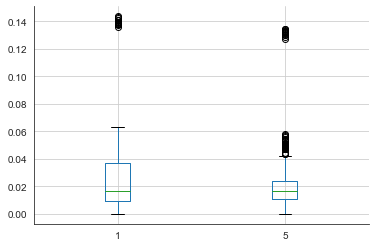

In [13]:
mutual_info.boxplot()
sns.despine();

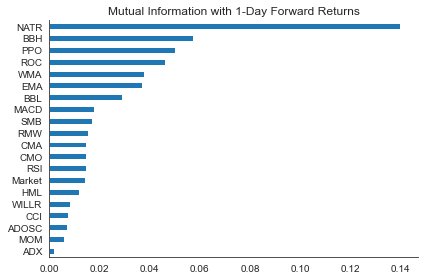

In [14]:
(mutual_info.groupby(mutual_info.index.to_series().str.split('_').str[-1])[1]
 .mean()
 .sort_values().plot.barh(title='Mutual Information with 1-Day Forward Returns'))
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'mutual_info_cnn_features', dpi=300)

In [15]:
best_features = mi_by_indicator.head(15).index

In [16]:
size = len(best_features)

## Hierarchical Feature Clustering

In [17]:
features = pd.concat([features.filter(like=f'_{f}') for f in best_features], axis=1)

In [18]:
new_cols = {}
for feature in best_features:
    fnames = sorted(features.filter(like=f'_{feature}').columns.tolist())
    renamed = [f'{i:02}_{feature}' for i in range(1, len(fnames)+ 1)]
    new_cols.update(dict(zip(fnames, renamed)))
features = features.rename(columns=new_cols).sort_index(1)

In [19]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2378283 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('ZTS', Timestamp('2017-12-28 00:00:00'))
Columns: 225 entries, 01_BBH to 15_WMA
dtypes: float64(225)
memory usage: 4.0+ GB


## Hierarchical Clustering

In [20]:
def cluster_features(data, labels, ax, title):
    data = StandardScaler().fit_transform(data)
    pairwise_distance = pdist(data)
    Z = linkage(data, 'ward')
    c, coph_dists = cophenet(Z, pairwise_distance)
    dend = dendrogram(Z,
                      labels=labels,
                      orientation='top',
                      leaf_rotation=0.,
                      leaf_font_size=8.,
                      ax=ax)
    ax.set_title(title)
    return dend['ivl']

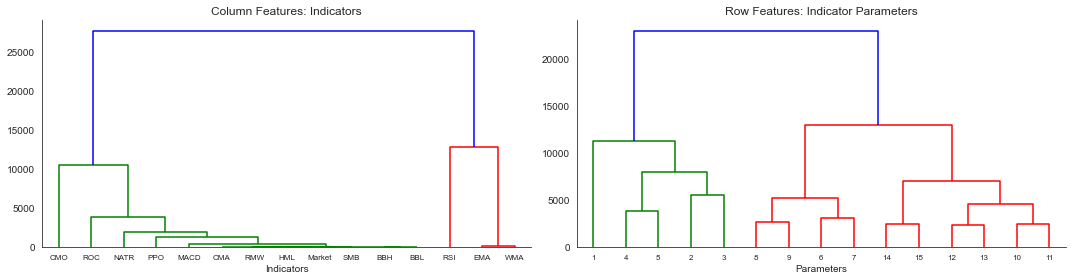

In [21]:
fig, axes = plt.subplots(figsize=(15, 4), ncols=2)

labels = sorted(best_features)
title = 'Column Features: Indicators'
col_order = cluster_features(features.dropna().values.reshape(-1, 15).T,
                             labels,
                             axes[0],
                             title)

labels = list(range(1, 16))
title = 'Row Features: Indicator Parameters'
row_order = cluster_features(
    features.dropna().values.reshape(-1, 15, 15).transpose((0, 2, 1)).reshape(-1, 15).T,
    labels, axes[1], title)
axes[0].set_xlabel('Indicators')
axes[1].set_xlabel('Parameters')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'cnn_clustering', dpi=300)

In [22]:
feature_order = [f'{i:02}_{j}' for i in row_order for j in col_order]

In [23]:
features = features.loc[:, feature_order]

In [24]:
features = features.apply(pd.to_numeric, downcast='float')

In [25]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2378283 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('ZTS', Timestamp('2017-12-28 00:00:00'))
Columns: 225 entries, 01_CMO to 11_WMA
dtypes: float32(225)
memory usage: 2.0+ GB


In [26]:
features.to_hdf('data.h5', 'img_data')